In [1]:
import os
import gc
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.utils import class_weight

from astropy.io import fits
from astropy.visualization import ZScaleInterval


C:\Users\ybouq\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ybouq\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ybouq\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ybouq\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

Seeding the randomizer for reproducibility. We note that the validation set and training set will not change between two sessions.

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [3]:
# Set some parameters
im_width = 64
im_height = 64
border = 5

In [4]:
datapath = 'trainset/'

In [5]:
x_train = np.load(datapath + '64_x.npy', allow_pickle = True)[:,0]
y_train = np.load(datapath + '64_y.npy', allow_pickle = True)
hs = np.load(datapath + '64_z.npy', allow_pickle = True)

In [8]:
#remove nan samples
indices = np.unique(np.argwhere(~np.isnan(x_train))[:,0])
x_train = x_train[indices]
y_train = y_train[indices]
hs = hs[indices]

We check the number of satellites and the ratio of samples containing a satellite

In [9]:
np.sum(hs), np.sum(hs)/len(hs)

(19250, 0.501341250618538)

In [10]:
n,h,w = x_train.shape

Generation of training set and validation (test) set

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(x_train.reshape(n,h,w,1), y_train.reshape(n,h,w,1), test_size=0.2, random_state=42)
del x_train
gc.collect()

256

Simplified version of the UNET's convolution block

In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    """
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)"""
    
    return x

In [14]:
# UNET generator
def get_unet(input_img, n_filters = 32, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [15]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=1e-5, verbose=1),
]

We define the jaccard distance as a metric to measure the performance of our model during its training

In [16]:
def jaccard_distance(y_true, y_pred):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + 100.) / (sum_ - intersection + 100.)
    jd =  (1 - jac) * 100.
    return tf.reduce_mean(jd)

In [17]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters= 32, dropout=0.1, batchnorm=True)
model.compile(optimizer=Adam(lr =1e-2), loss="binary_crossentropy", metrics=[jaccard_distance])


In [117]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 64, 64, 32)   128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 64, 64, 32)   0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [26]:
results_32_s40k_d1bn = model.fit(X_train, y_train, batch_size=10, epochs=100, \
                    callbacks= callbacks + [ModelCheckpoint('model-32-s40k-d1bn-1.h5', verbose=1, save_best_only=True, save_weights_only=True)],\
                    validation_data=(X_valid, y_valid))

Train on 30717 samples, validate on 7680 samples
Epoch 1/100
30717/30717 [==============================] - 1312s 43ms/step - loss: 0.0130 - jaccard_distance: 12.5985 - val_loss: 0.0075 - val_jaccard_distance: 7.0867

Epoch 00001: val_loss improved from inf to 0.00754, saving model to model-32-s40k-d1bn-1.h5
Epoch 2/100
30717/30717 [==============================] - 1348s 44ms/step - loss: 0.0073 - jaccard_distance: 7.2438 - val_loss: 0.0091 - val_jaccard_distance: 6.4184

Epoch 00002: val_loss did not improve from 0.00754
Epoch 3/100
30717/30717 [==============================] - 1286s 42ms/step - loss: 0.0065 - jaccard_distance: 6.3925 - val_loss: 0.0103 - val_jaccard_distance: 7.2738

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00003: val_loss did not improve from 0.00754
Epoch 4/100
30717/30717 [==============================] - 1430s 47ms/step - loss: 0.0052 - jaccard_distance: 5.0722 - val_loss: 0.0048 - val_jaccard_distance: 4.4414

Epo

We save the history of the training

In [27]:
keys = results_32_s40k_d1bn.history.keys()
for i in keys:
    np.save('./np_results/'+'32_s40k_d1bn_'+ i +'_1.npy', results_32_s40k_d1bn.history[i])

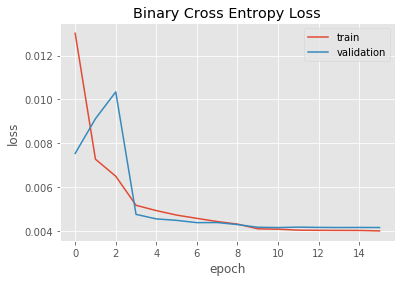

In [33]:
plt.plot(results['loss'])
plt.plot(results['val_loss'])
plt.title('Binary Cross Entropy Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('full_final_loss.png')
plt.show()

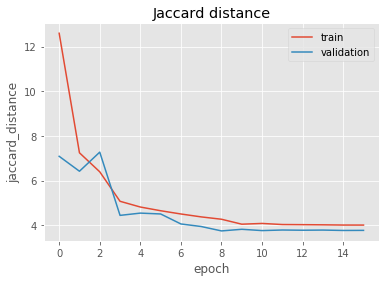

In [32]:
plt.plot(results['jaccard_distance'])
plt.plot(results['val_jaccard_distance'])
plt.title('Jaccard distance')
plt.ylabel('jaccard_distance')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('full_final_jd.png')

plt.show()


Testing the model after training

In [27]:
# You can run this cell if you want to skip the training
"""input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters= 32, dropout=0.1, batchnorm=True)
model.load_weights('model_951.h5')"""

In [28]:
valid_preds = model.predict(X_valid)

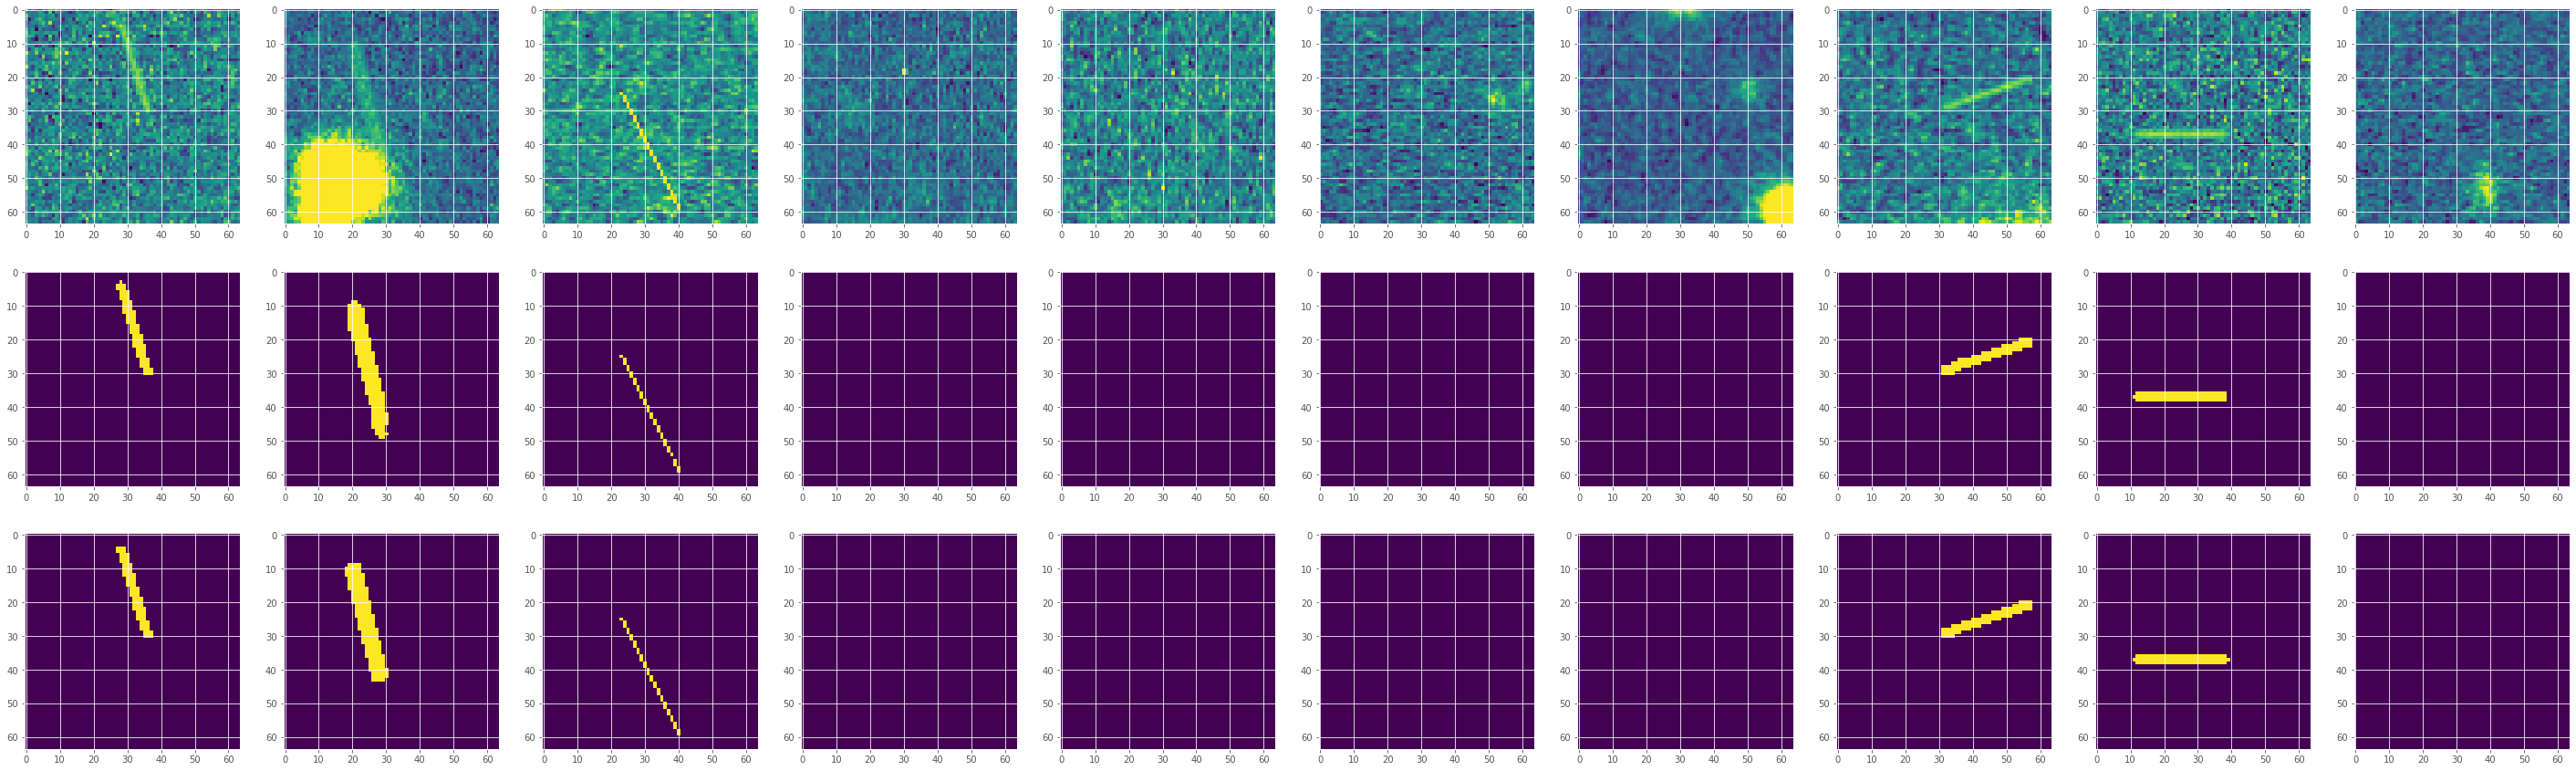

In [43]:
adds = np.arange(len(valid_preds)) 
np.random.shuffle(adds)

f, axes = plt.subplots(3,10, figsize=(50,15))
for i, pred in enumerate(valid_preds[adds[:10]]):
    axes[0,i].imshow(X_valid[adds[i],:,:,0])
    axes[1, i].imshow(pred[:,:,0] > 0.5)
    axes[2,i].imshow(y_valid[adds[i],:,:,0])
plt.savefig('unet_32_full_final.png')
plt.show()

In [22]:
def get_patch_accuracy(predictions, true_values):
    """
    The patch accuracy defines the performance of the model to detect if a 64x64 block contains a satellite or not.
    (image classification)
    """
    n = len(predictions)
    masks = np.any(predictions.reshape(n, -1) > 0.7, axis = -1)
    true_patches = np.any(true_values.reshape(n, -1), axis = -1)
    tmp = 1*(masks == true_patches)
    result = np.mean(tmp)
    #errors = np.argwhere(tmp == 0).ravel()
    return result#, errors

In [23]:
get_patch_accuracy(valid_preds, y_valid)

0.987890625

In [24]:
def get_tp(patch_pred, patch_true):
    return np.sum(patch_pred * patch_true)

def get_tn(patch_pred, patch_true):
    return np.sum((1-patch_pred) * (1-patch_true))

def get_fp(patch_pred, patch_true):
    return np.sum(patch_pred * (1-patch_true))

def get_fn(patch_pred, patch_true):
    return np.sum((1-patch_pred)*patch_true)

def pixwise_f1(predictions, true_values):
    """
    Model performance for image segmentation on a 64x64 block (f1 score)
    """
    n = predictions.shape[0]
    final_preds = 1*(predictions > 0.5)
    tp,tn,fp,fn = get_tp(final_preds, true_values), get_tn(final_preds, true_values), get_fp(final_preds, true_values), get_fn(final_preds, true_values)
    return (tp / (tp + (1/2) * (fp + fn)))

def patchwise_f1(predictions, true_values):
    """
    Model performance for image classification (f1 score)
    """
    n = predictions.shape[0]
    patch_preds = np.any(predictions.reshape(n, -1) > 0.7, axis = -1)*1
    patch_gt = np.any(true_values.reshape(n, -1), axis = -1)*1
    tp,tn,fp,fn = get_tp(patch_preds, patch_gt), get_tn(patch_preds, patch_gt), get_fp(patch_preds, patch_gt), get_fn(patch_preds, patch_gt)
    print(tp, tn, fp, fn, n == tp+tn+fp+fn) #simple verifications for the computations
    return (tp / (tp + (1/2) * (fp + fn)))


In [25]:
patchwise_f1(valid_preds, y_valid)

3757 3830 20 73 True


0.9877744182989352

In [26]:
pixwise_f1(valid_preds, y_valid)

0.9510999224272939

In [46]:
from mosaic import scale_image, get_raw_image, get_blocks_addresses, get_block

In [92]:
raw_image,unscaled_img = get_raw_image("../Lesta/satellites/OMEGA.2020-01-28T03_17_31.123_fullfield_binned.fits")
crops_addresses = get_blocks_addresses(raw_image)

C:\Users\ybouq\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
C:\Users\ybouq\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [93]:
x_ = list(crops_addresses.keys())[1]
crop = get_block(raw_image, x_, crops_addresses[x_][-1])
crop = ((crop - np.min(crop)) / (np.max(crop) -  np.min(crop)) * 255).astype(int).astype(float)
crop = (crop - np.min(crop)) / (np.max(crop) -  np.min(crop))

Model performance on a single true sample, the block being centered on the satellite streak.

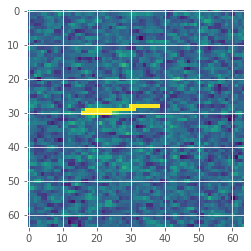

In [94]:
natural_sat = crop[875:64+875, 950:1014]
plt.imshow(natural_sat)
plt.savefig('natural_sat.png')

Raw output of the model

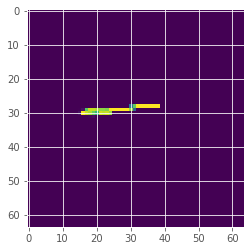

In [95]:
output_model = model.predict(natural_sat.reshape(1,64,64,1)).reshape(64,64)
plt.imshow(output_model)

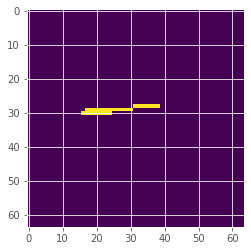

In [58]:
plt.imshow(output_model>0.5)
plt.savefig('natural_prediction.png') 

Applying the predictive model on the whole block (modulo 64) to observe possible false positives: 

In [96]:
h,w = crop.shape
crop_results = np.zeros(crop.shape).astype(np.uint8)
subh, subw = 64,64
for alpha in range(0,h, subh):
    for beta in range(0,w, subw):
        if (alpha + subh) <= h and (beta+subw) <= w :
            subcrop = crop[alpha:alpha+subh, beta:beta+subw].reshape(1,subh,subw,1)
            pred = 1*(model.predict(subcrop).reshape(subh,subw)>0.5)
            crop_results[alpha:alpha+subh, beta:beta+subw] = pred
            

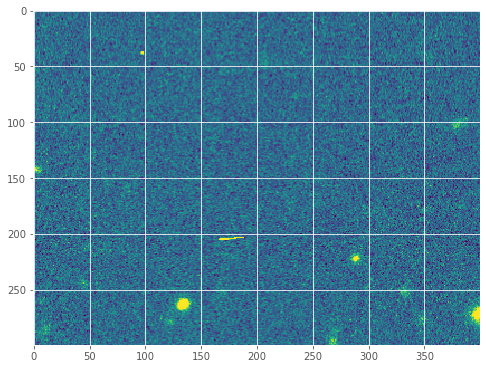

In [98]:
#Input
plt.figure(figsize = (8,8))
plt.imshow(crop[700:1000,800:1200])
plt.savefig('full_block_prediction_b.png')

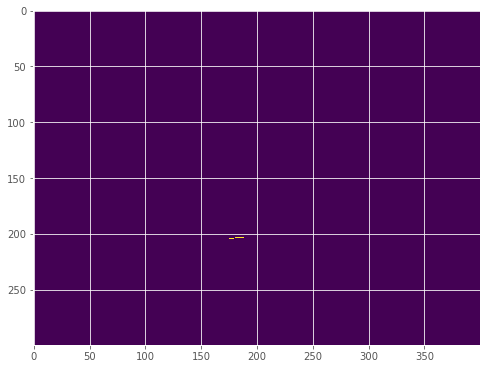

In [97]:
#MODEL OUTPUT
plt.figure(figsize = (8,8))
plt.imshow(crop_results[700:1000, 800:1200])
plt.savefig('full_block_prediction_a.png')

Applying the model on a block (modulo 64) containing a long streak

In [99]:
raw_image,unscaled_img = get_raw_image("../Lesta/satellites/OMEGA.2020-01-28T03_23_35.394_fullfield_binned.fits")
crops_addresses = get_crops_addresses(raw_image)


C:\Users\ybouq\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
C:\Users\ybouq\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [102]:
x_ = list(crops_addresses.keys())[1]
crop = get_crop(raw_image, x_, crops_addresses[x_][4])
crop = ((crop - np.min(crop)) / (np.max(crop) -  np.min(crop)) * 255).astype(int).astype(float)
crop = (crop - np.min(crop)) / (np.max(crop) -  np.min(crop))

In [111]:
import time
start = time.time()
h,w = crop.shape
crop_results_2= np.zeros(crop.shape).astype(np.uint8)
subh, subw = 64,64
for alpha in range(0,h, subh):
    for beta in range(0,w, subw):
        if (alpha + subh) <= h and (beta+subw) <= w :
            subcrop = crop[alpha:alpha+subh, beta:beta+subw].reshape(1,subh,subw,1)
            pred = 1*(model.predict(subcrop).reshape(subh,subw)>0.5)
            crop_results_2[alpha:alpha+subh, beta:beta+subw] = pred
end = time.time()

In [116]:
(end - start)

19.52002787590027

=> The image segmentation of a full block takes 20 seconds with the current neural network model. 

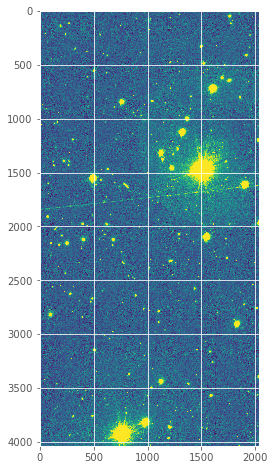

In [107]:
#INPUT
plt.figure(figsize = (8,8))
plt.imshow(crop)
plt.savefig('long_track_unet.png')

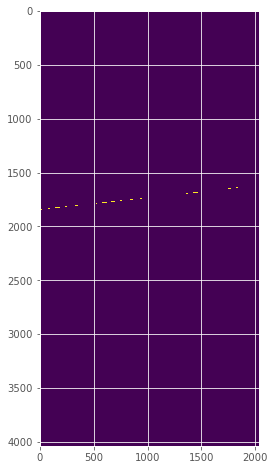

In [109]:
#MODEL OUTPUT
plt.figure(figsize = (8,8))
plt.imshow(crop_results_2)
plt.savefig('long_track_predictions_unet.png')